In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
# sys.path.append('/Users/koush/Projects/sctools')
# sys.path.append('/Users/koush/Projects/platter')

# from sctools import sctools as sct
# from sctools import utils as sctu
# from platter import plat

In [5]:
import flowsig as fs
import commot as ct
import scanpy as sc

In [6]:
adata = sc.read_h5ad('./.cache/adata_train.h5ad')

In [7]:
df_ligrec = ct.pp.ligand_receptor_database(
    database='CellChat', 
    species='mouse', 
    signaling_type=None
)

In [8]:
%%time

ct.tl.spatial_communication(
    adata,
    database_name='user_database', 
    df_ligrec=df_ligrec, dis_thr=250, 
    heteromeric=True,
)

CPU times: user 3min 9s, sys: 14.3 s, total: 3min 23s
Wall time: 3min 24s


In [9]:
%%time

fs.pp.construct_gems_using_nsf(
    adata,
    n_gems = 10,
    layer_key = 'raw_count',
    length_scale = 5.0
)

Temporary checkpoint directory: /var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/tmpvzuv4a4j
0050 train: 7.137e+02
0100 train: 6.828e+02
0150 train: 6.717e+02, chg: 3.58e-04
0200 train: 6.657e+02, chg: 1.52e-04
0250 train: 6.621e+02, chg: 9.49e-05
0300 train: 6.596e+02, chg: 6.42e-05
0350 train: 6.580e+02, chg: 4.57e-05
0400 train: 6.567e+02, chg: 3.43e-05
0400 training complete, converged.
CPU times: user 1h 2min 8s, sys: 15min 11s, total: 1h 17min 20s
Wall time: 9min 18s


In [15]:
[pair.replace('r-', '') for pair in adata.obsm[commot_output_key + '-sum-receiver'].columns if pair.startswith('r-' + lig)]

False

In [16]:
commot_output_key = 'commot-user_database'

In [25]:
fs.pp.construct_flows_from_commot(
    adata,
    'commot-user_database',
    gem_expr_key = 'X_gem',
    scale_gem_expr = True,
    flowsig_network_key = 'flowsig_network',
    flowsig_expr_key = 'X_flow'
)

In [26]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=20, random_state=0).fit(adata.obsm['spatial'])
adata.obs['spatial_kmeans'] = pd.Series(kmeans.labels_, dtype='category').values

fs.tl.learn_intercellular_flows(
    adata,
    flowsig_key = 'flowsig_network',
    flow_expr_key = 'X_flow',
    use_spatial = True,
    block_key = 'spatial_kmeans',
    n_jobs = 10,
    n_bootstraps = 500,
    alpha_ci = 0.1,
    alpha_inv = 0.1
)

starting computations on 10 cores
elapsed time: 245.96479725000017


In [27]:
fs.tl.apply_biological_flow(adata,
                            flowsig_network_key = 'flowsig_network',
                            adjacency_key = 'adjacency',
                            validated_key = 'validated');

edge_threshold = 0.8
fs.tl.filter_low_confidence_edges(adata,
                                edge_threshold = edge_threshold,
                                flowsig_network_key = 'flowsig_network',
                                adjacency_key = 'adjacency_validated',
                                filtered_key = 'filtered');

[[0.   0.   0.   ... 0.03 0.04 0.05]
 [0.   0.   0.   ... 0.18 0.21 0.26]
 [0.   0.   0.   ... 0.16 0.16 0.16]
 ...
 [0.12 0.18 0.15 ... 0.   0.47 0.46]
 [0.16 0.24 0.2  ... 0.53 0.   0.51]
 [0.15 0.27 0.19 ... 0.5  0.49 0.  ]]
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.47 0.46]
 [0.   0.   0.   ... 0.53 0.   0.51]
 [0.   0.   0.   ... 0.5  0.49 0.  ]]


In [28]:
adata.uns['flowsig_network']['flow_var_info']

,Type,Downstream_TF,Interaction
Angptl2,outflow,,Angptl2-Pirb
Angptl4,outflow,,Angptl4-Cdh5/Angptl4-Sdc2/Angptl4-Sdc4
App,outflow,,App-Cd74
Bmp2,outflow,,Bmp2-Bmpr1a_Acvr2a/Bmp2-Bmpr1a_Bmpr2
C3,outflow,,C3-Cr2
...,...,...,...
GEM-6,module,,
GEM-7,module,,
GEM-8,module,,
GEM-9,module,,


In [29]:
adata

AnnData object with n_obs × n_vars = 10277 × 4998
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'spatial_kmeans'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'hvg', 'log1p', 'rctd_cluster_colors', 'commot-user_database-info', 'nsf_info', 'flowsig_network'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'spatial_maps', 'commot-user_database-sum-sender', 'commot-user_database-sum-receiver', 'X_gem', 'X_flow'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'commot-user_database-Fcer2a-Cr2', 'commot-user_databas

In [30]:
del adata.obsm['spatial_maps']

In [33]:
adata.write_h5ad('../data/flowsig/adata_train_flowsig.h5ad')

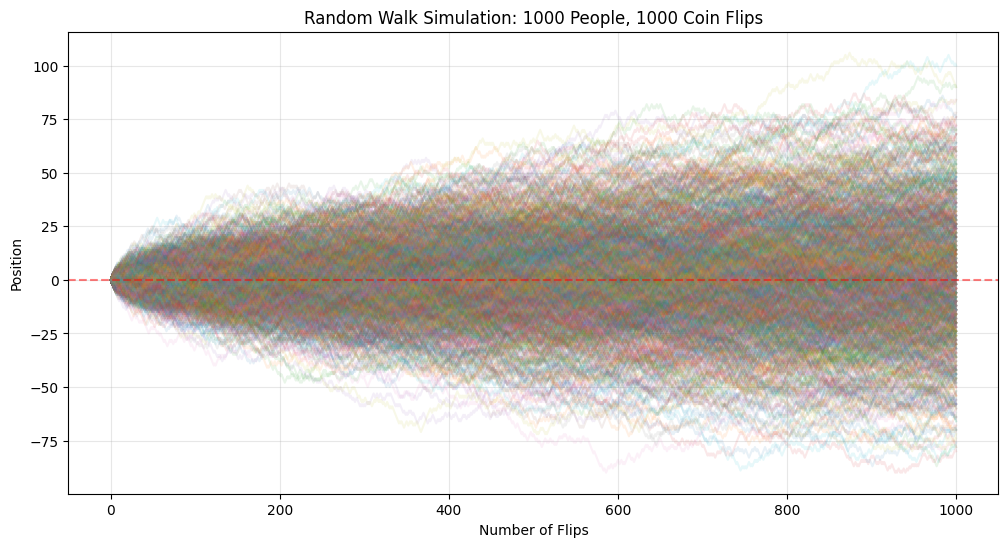

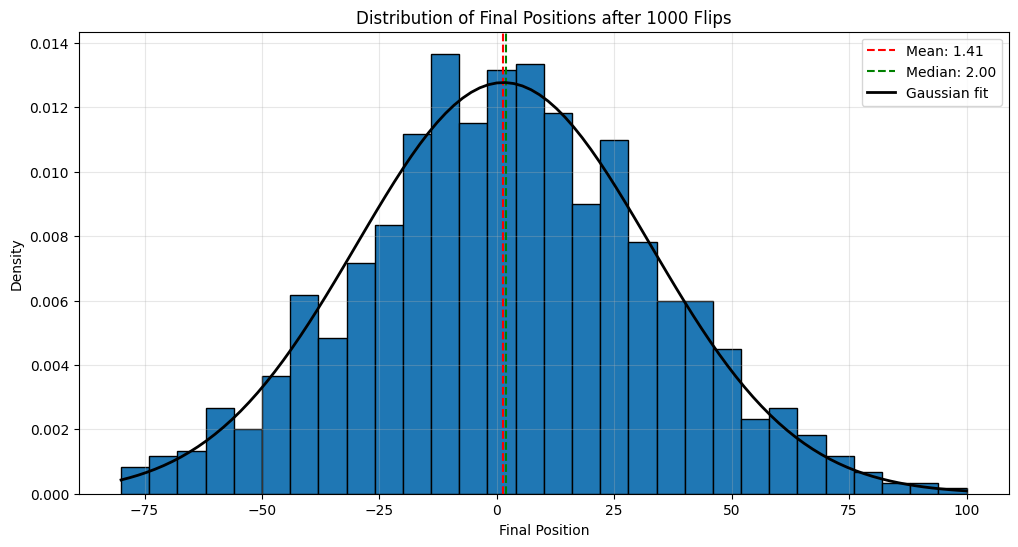

Mean final position: 1.41
Median final position: 2.00
Standard deviation of final positions: 31.23

Shapiro-Wilk test for normality:
Statistic: 0.9979
p-value: 0.2598
The distribution is normally distributed (α = 0.05)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set up simulation parameters
num_people = 1000
num_flips = 1000

# Run simulation
positions = np.zeros((num_people, num_flips + 1))
for flip in range(1, num_flips + 1):
    step = np.random.choice([-1, 1], size=num_people)
    positions[:, flip] = positions[:, flip - 1] + step

# Plot results
plt.figure(figsize=(12, 6))
for person in range(num_people):
    plt.plot(range(num_flips + 1), positions[person, :], alpha=0.1)

plt.title(f"Random Walk Simulation: {num_people} People, {num_flips} Coin Flips")
plt.xlabel("Number of Flips")
plt.ylabel("Position")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and plot summary statistics
final_positions = positions[:, -1]
plt.figure(figsize=(12, 6))
hist, bin_edges, _ = plt.hist(final_positions, bins=30, edgecolor='black', density=True)
plt.title(f"Distribution of Final Positions after {num_flips} Flips")
plt.xlabel("Final Position")
plt.ylabel("Density")
plt.axvline(x=np.mean(final_positions), color='r', linestyle='--', label=f'Mean: {np.mean(final_positions):.2f}')
plt.axvline(x=np.median(final_positions), color='g', linestyle='--', label=f'Median: {np.median(final_positions):.2f}')

# Add Gaussian overlay
mu, std = np.mean(final_positions), np.std(final_positions)
x = np.linspace(min(final_positions), max(final_positions), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian fit')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean final position: {np.mean(final_positions):.2f}")
print(f"Median final position: {np.median(final_positions):.2f}")
print(f"Standard deviation of final positions: {np.std(final_positions):.2f}")

# Perform Shapiro-Wilk test for normality
statistic, p_value = stats.shapiro(final_positions)
print(f"\nShapiro-Wilk test for normality:")
print(f"Statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"The distribution is {'not ' if p_value < 0.05 else ''}normally distributed (α = 0.05)")
